In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row

In [5]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_8800\667666233.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [6]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - zadnji krajec

Preverila bom, če se ritmičnost nesreč, ki so se zgodile med zadnjim krajcem, razlikuje od ritmičnosti ostalih nesreč.

In [8]:
# Maska za luno
moon_mask = (accidents_moon['moon_phase'] == 'Last Quarter')

accidents_last_quarter = accidents_moon[moon_mask]
# display(accidents_last_quarter)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_last_quarter['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsLastQ",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

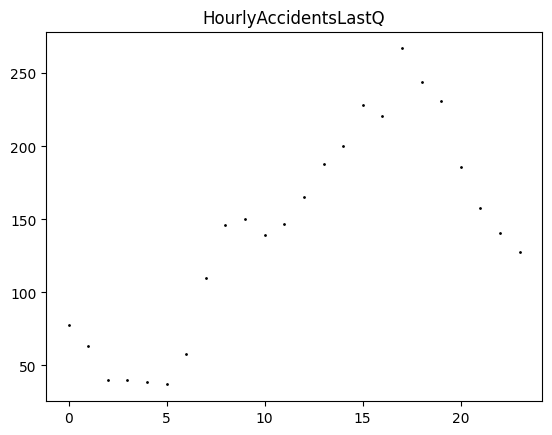

In [9]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsLastQ"])

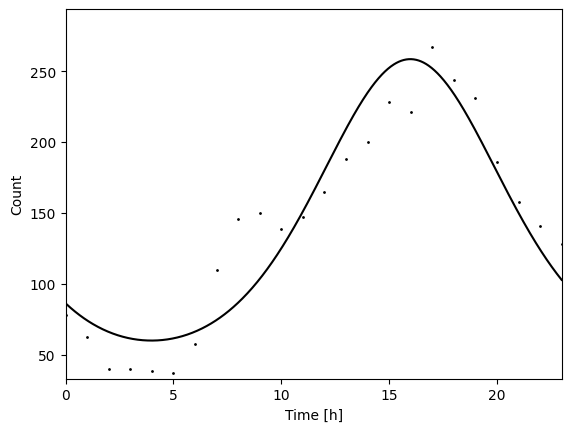

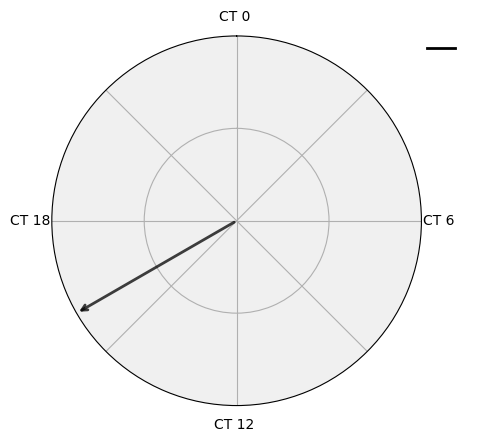

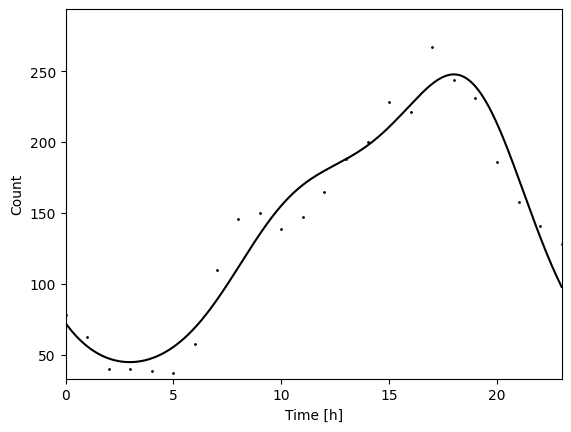

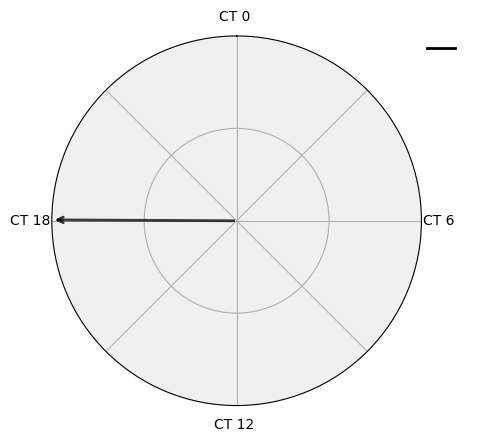

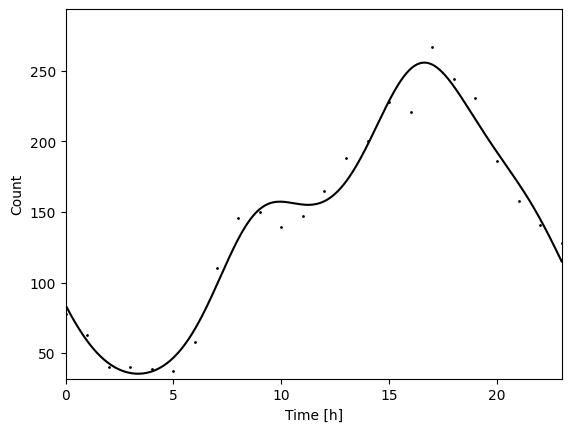

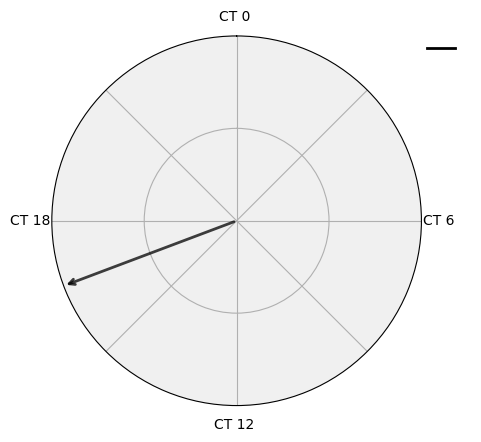

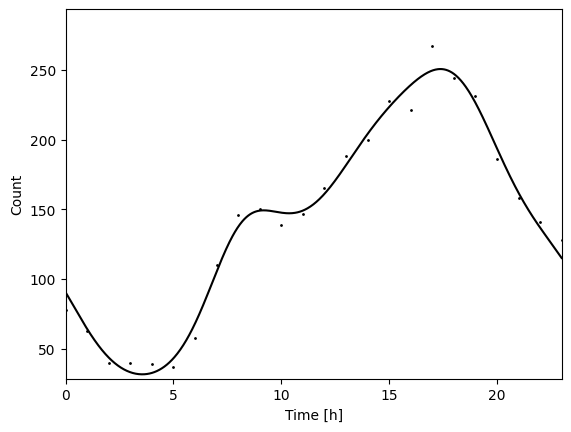

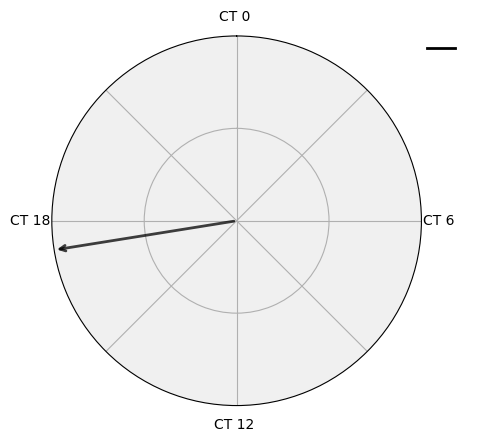

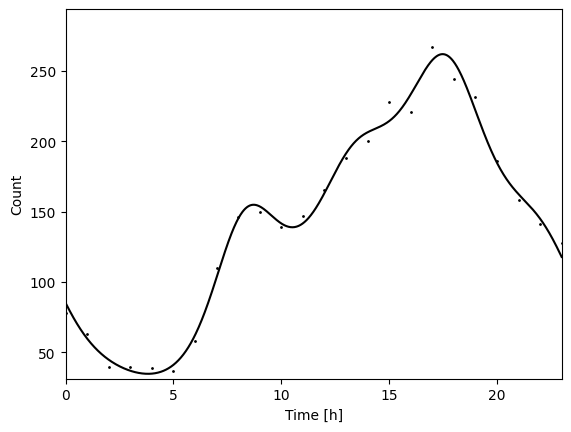

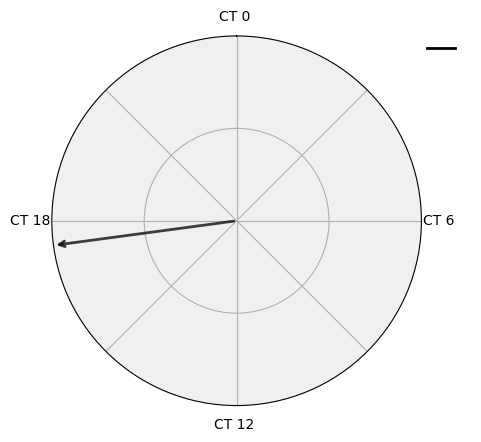

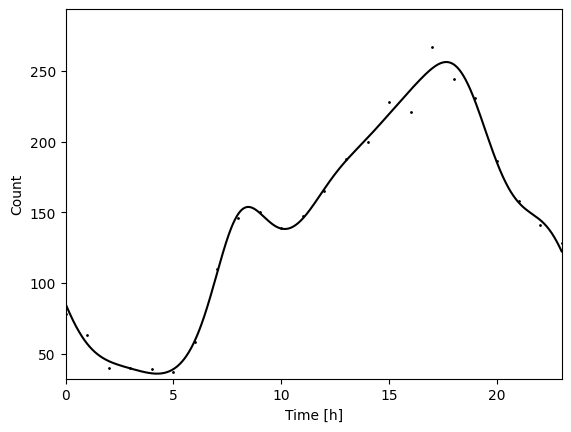

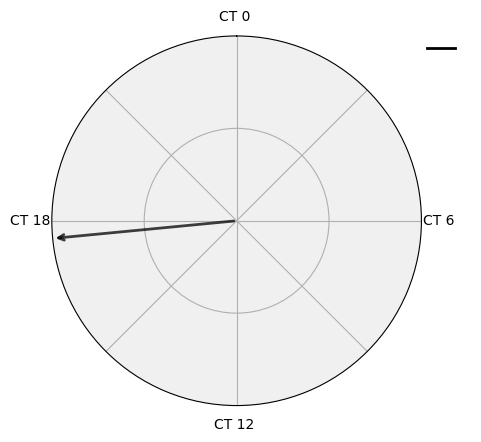

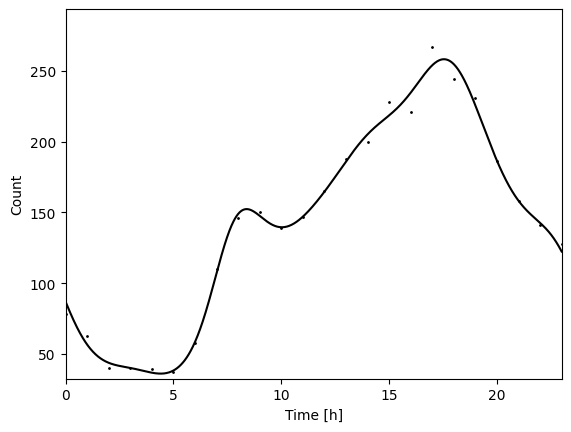

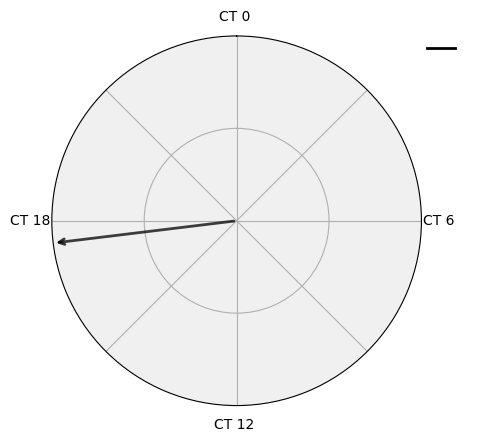

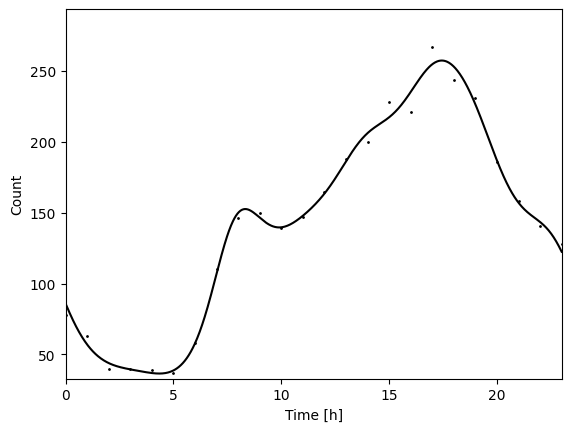

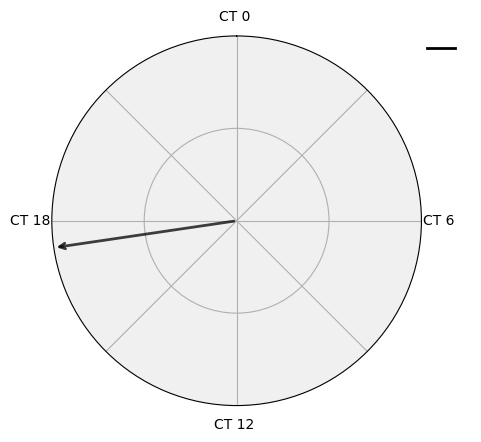

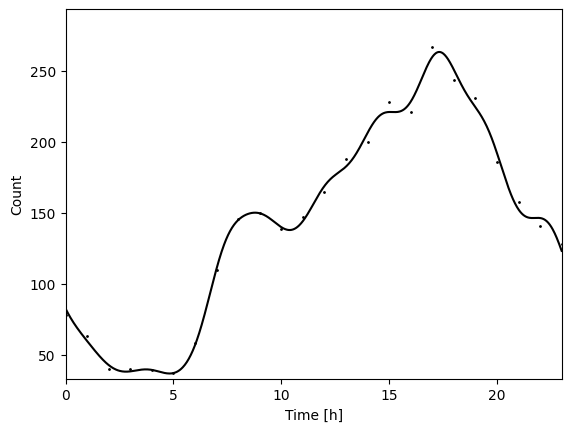

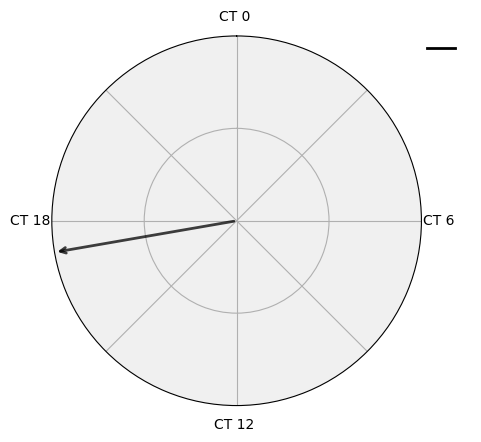

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


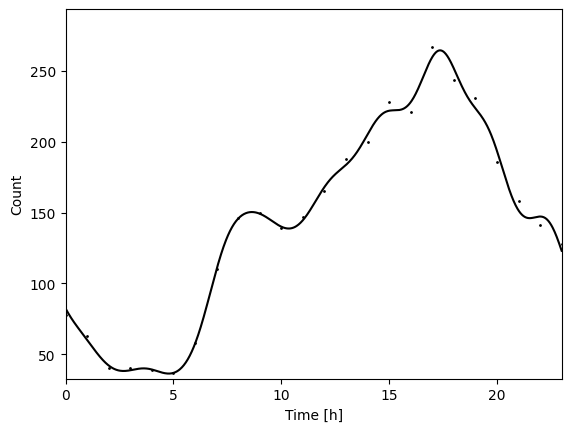

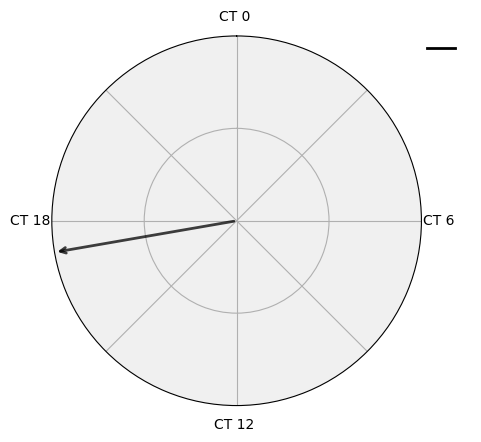

In [10]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsLastQ', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [11]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsLastQ,24.0,1.0,1.110825e-11,1.110825e-11,15339.544339,-112.288897,0.183426,99.136847,2.094395,159.321744,[16.0],[258.45671207103953],[3.987987987987988],[60.184896620342045]
1,HourlyAccidentsLastQ,24.0,2.0,6.889584e-15,7.655093e-15,6643.732655,-101.286463,0.263437,101.358811,1.566079,146.358056,[18.01801801801802],[247.71548133150063],[2.978978978978979],[44.999245077410905]
2,HourlyAccidentsLastQ,24.0,3.0,2.531783e-18,3.164728e-18,3099.469578,-89.920436,0.346091,110.204408,1.930869,145.603814,"[9.945945945945946, 16.624624624624623]","[157.29560151798552, 255.80822186338276]",[3.3633633633633635],[35.399405910595966]
3,HourlyAccidentsLastQ,24.0,4.0,2.945508e-19,4.207869e-19,1588.410786,-84.676282,0.384227,109.558203,1.729606,141.136782,"[9.177177177177176, 17.393393393393392]","[149.27563377597403, 250.69360127268052]",[3.5555555555555554],[31.578578502369645]
4,HourlyAccidentsLastQ,24.0,5.0,7.531647e-21,2.510549e-20,1097.556655,-77.937959,0.433229,113.441050,1.704448,148.317870,"[8.696696696696696, 17.48948948948949]","[154.85695727289377, 261.75891941165287]","[3.795795795795796, 10.522522522522522]","[34.878846851537766, 138.8859505553172]"
5,HourlyAccidentsLastQ,24.0,6.0,2.223076e-21,1.533395e-20,877.777241,-73.899825,0.462595,110.234475,1.666711,146.044085,"[8.456456456456456, 17.633633633633632]","[153.75982367384623, 256.2762568300443]","[4.228228228228228, 10.138138138138139]","[35.80960999553363, 138.16108091193666]"
6,HourlyAccidentsLastQ,24.0,7.0,1.194700e-20,2.986750e-20,816.698519,-73.132772,0.468173,111.112546,1.691869,147.174038,"[8.408408408408409, 17.53753753753754]","[152.35366237457686, 258.2865837601973]","[4.42042042042042, 10.042042042042041]","[36.062498727553034, 139.52620694372587]"
7,HourlyAccidentsLastQ,24.0,8.0,8.946058e-20,1.491010e-19,809.015517,-72.883701,0.469984,110.434537,1.717027,146.988211,"[8.312312312312311, 17.44144144144144]","[152.63100609566916, 257.42274828659555]","[4.324324324324325, 9.897897897897899]","[36.55462224252867, 139.6563836730198]"
8,HourlyAccidentsLastQ,24.0,9.0,3.066790e-21,1.533395e-20,503.154932,-66.683121,0.515075,113.347696,1.742185,150.149733,"[8.792792792792794, 15.03903903903904, 17.3453...","[150.18536158514928, 221.18585184751856, 263.4...","[2.7867867867867866, 4.804804804804805, 10.378...","[38.103124302626895, 36.80203676599769, 137.95..."
9,HourlyAccidentsLastQ,24.0,10.0,1.805155e-20,3.610310e-20,510.808694,-66.333293,0.517619,114.116939,1.742185,150.466676,[17.345345345345343],[264.5743653790094],"[2.6906906906906904, 4.756756756756757, 10.330...","[38.18113387961562, 36.35445078268592, 138.770..."


### Katero je najboljše število komponent

In [12]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsLastQ,24.0,4.0,2.945508e-19,4.207869e-19,1588.410786,-84.676282,0.384227,109.558203,1.729606,141.136782,"[9.177177177177176, 17.393393393393392]","[149.27563377597403, 250.69360127268052]",[3.5555555555555554],[31.578578502369645]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


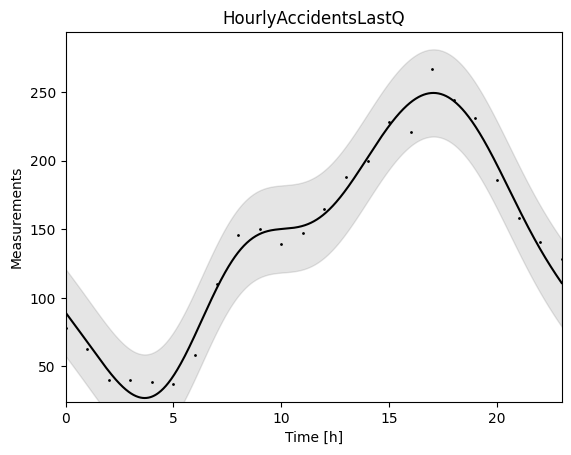

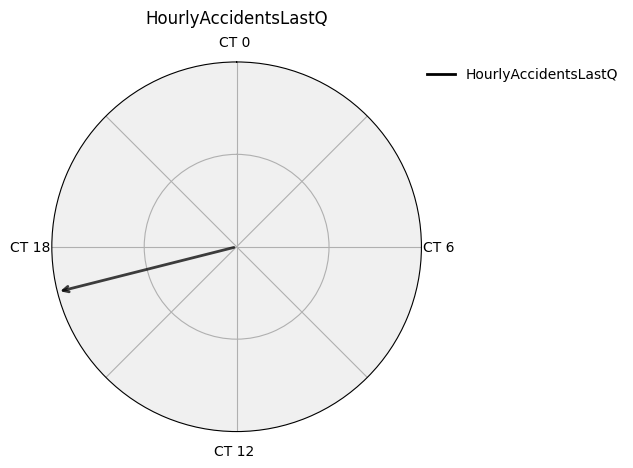

In [13]:
cosinor.plot_df_models(df_plot, df_best_model)